<a href="https://colab.research.google.com/github/tj-mas04/Breast-Cancer-Detection-with-Radiological-Images_SVM/blob/main/PCA_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rarfile

In [2]:
# Unzipping the dataset (assuming you've uploaded it to Colab)
import os
from zipfile import ZipFile
import rarfile

# Path to your dataset file (modify the path if needed)
dataset_path = '/content/Dataset.rar'

# Unzip the .rar file
with rarfile.RarFile(dataset_path, 'r') as rf:
    rf.extractall('/content/dataset')

# After extraction, the images should be in /content/dataset folder


In [3]:
# Cell 1: Import Libraries
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from skimage.feature import hog, local_binary_pattern
import joblib
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA


In [4]:
# Cell 2: Define Image Preprocessing and Loading Functions
data_dir = '/content/dataset/'  # Change path if necessary
IMG_SIZE = 128  # Resize images to 128x128

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    return img_normalized

def load_images(data_dir):
    images, labels = [], []
    for label in ['benign', 'malignant']:  # Assuming subfolders for each class
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(label)
    # Convert to numpy arrays and encode labels
    images, labels = np.array(images), np.array(labels)
    labels_encoded = LabelEncoder().fit_transform(labels)
    return images, labels_encoded

# Load images and labels
images, labels = load_images(data_dir)


In [5]:
# Cell 3: Define Feature Extraction Functions
def extract_hog_features(images):
    hog_features = [hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys') for img in images]
    return np.array(hog_features)

def extract_sift_features(images):
    sift = cv2.SIFT_create()
    sift_features = []
    for img in images:
        img_uint8 = (img * 255).astype('uint8')
        kp, des = sift.detectAndCompute(img_uint8, None)
        sift_features.append(np.ravel(des)[:128] if des is not None else np.zeros(128))
    return np.array(sift_features)

def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float") / hist.sum()  # Normalize
        lbp_features.append(hist)
    return np.array(lbp_features)

def extract_color_histograms(images, bins=64):
    color_hist_features = []
    for img in images:
        img_8bit = (img * 255).astype('uint8')
        hist = cv2.calcHist([img_8bit], [0], None, [bins], [0, 256])
        color_hist_features.append(cv2.normalize(hist, hist).flatten())
    return np.array(color_hist_features)

# Extract features
hog_features = extract_hog_features(images)
sift_features = extract_sift_features(images)
lbp_features = extract_lbp_features(images)
color_hist_features = extract_color_histograms(images)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [6]:
# Cell 4: Concatenate All Features and Perform Train-Test Split
X = np.hstack((hog_features, sift_features, lbp_features, color_hist_features))
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


In [ ]:
# Cell 5: Train and Evaluate SVM Classifier without PCA
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=['Benign', 'Malignant']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save the trained model
joblib.dump(svm_clf, 'svm_breast_cancer_model.pkl')


In [7]:
# Cell 6: Apply PCA for Dimensionality Reduction and Retrain SVM
pca = PCA(n_components=100)  # Adjust n_components as needed
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42)

svm_clf_pca = SVC(kernel='linear')
svm_clf_pca.fit(X_train_pca, y_train)

# Evaluate PCA-based Model
y_pred_pca = svm_clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"SVM Accuracy with PCA: {accuracy_pca * 100:.2f}%")
print("Classification Report with PCA:\n", classification_report(y_test, y_pred_pca, target_names=['Benign', 'Malignant']))

# Save PCA and SVM models
joblib.dump(pca, 'pca_model.pkl')
joblib.dump(svm_clf_pca, 'svm_breast_cancer_model_with_pca.pkl')


SVM Accuracy with PCA: 67.65%
Classification Report with PCA:
               precision    recall  f1-score   support

      Benign       0.68      1.00      0.81       458
   Malignant       0.00      0.00      0.00       219

    accuracy                           0.68       677
   macro avg       0.34      0.50      0.40       677
weighted avg       0.46      0.68      0.55       677



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['svm_breast_cancer_model_with_pca.pkl']

In [17]:
# Cell 7: Define Prediction Function for New Images
def predict_image_with_pca(image_path, model, pca):
    img = preprocess_image(image_path)
    hog_feat = extract_hog_features([img])
    sift_feat = extract_sift_features([img])
    lbp_feat = extract_lbp_features([img])
    color_hist_feat = extract_color_histograms([img])
    features = np.hstack((hog_feat, sift_feat, lbp_feat, color_hist_feat))
    features_pca = pca.transform(features.reshape(1, -1))
    pred = model.predict(features_pca)
    return 'Malignant' if pred[0] == 1 else 'Benign'


In [26]:
# Cell 8: Load PCA and SVM Model and Test Prediction on a New Image
pca_model = joblib.load('pca_model.pkl')
svm_model_with_pca = joblib.load('svm_breast_cancer_model_with_pca.pkl')
new_image_path = '/content/dataset/Testing/1/30842_1408047595_png.rf.79c4b3e14de7ddfa5be4bb837f0ecd74.jpg'  # Update this path
result_with_pca = predict_image_with_pca(new_image_path, svm_model_with_pca, pca_model)
print(f"Prediction with PCA: {result_with_pca}")


Prediction with PCA: Benign


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction with PCA: Benign


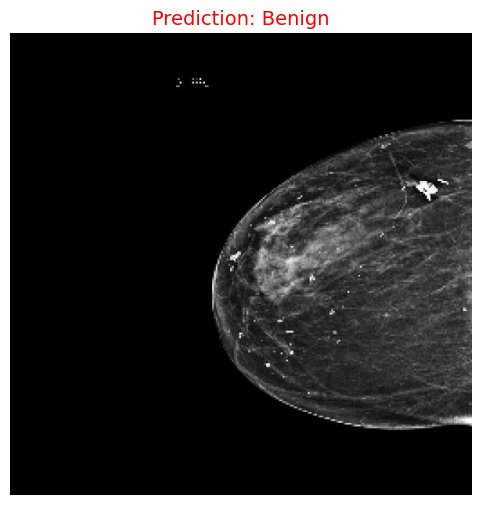

In [23]:
# Load PCA and SVM model
pca_model = joblib.load('pca_model.pkl')
svm_model_with_pca = joblib.load('svm_breast_cancer_model_with_pca.pkl')

# Path to a new image for prediction
new_image_path = '/content/dataset/malignant/10130_613462606_png.rf.eafac46ef469dfac664651c3789d2664.jpg'

# Get prediction result
result_with_pca = predict_image_with_pca(new_image_path, svm_model_with_pca, pca_model)
print(f"Prediction with PCA: {result_with_pca}")

# Display the image with the predicted label
def display_image_with_prediction(image_path, label):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb, cmap='gray')
    plt.title(f'Prediction: {label}', fontsize=14, color='red')
    plt.axis('off')  # Hide the axis
    plt.show()

# Display the prediction result
display_image_with_prediction(new_image_path, result_with_pca)


Test Accuracy with PCA: 67.65%


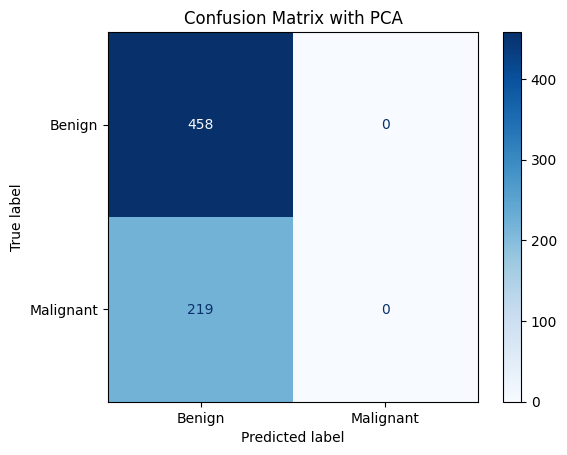

In [27]:
# Evaluate on test set
y_pred_with_pca = svm_model_with_pca.predict(pca_model.transform(X_test))
accuracy_with_pca = accuracy_score(y_test, y_pred_with_pca)
print(f"Test Accuracy with PCA: {accuracy_with_pca * 100:.2f}%")

# Confusion matrix
conf_matrix_with_pca = confusion_matrix(y_test, y_pred_with_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_with_pca, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with PCA')
plt.show()


Test Accuracy with PCA: 67.65%
Classification Report with PCA:
               precision    recall  f1-score   support

      Benign       0.68      1.00      0.81       458
   Malignant       0.00      0.00      0.00       219

    accuracy                           0.68       677
   macro avg       0.34      0.50      0.40       677
weighted avg       0.46      0.68      0.55       677



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


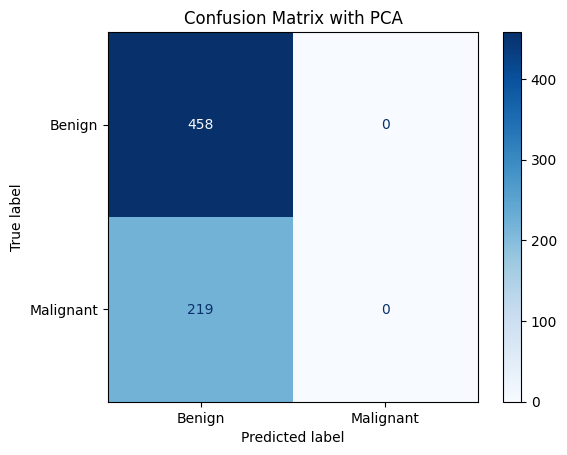

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


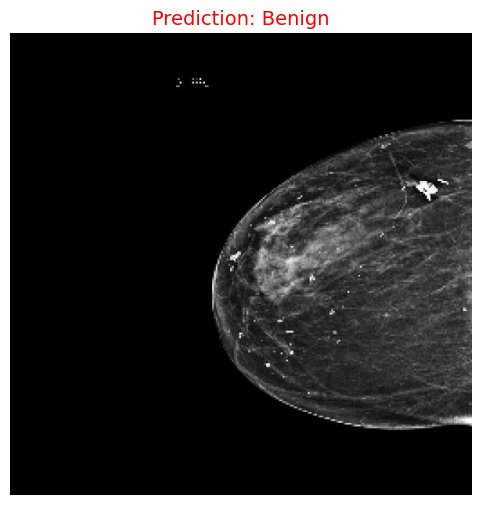

Predicted Label: Benign


In [28]:
# Confusion Matrix, Test Accuracy, Classification Report, and Display Predicted Image with Label

# Evaluate on the test set with the PCA-based model
y_pred_with_pca = svm_model_with_pca.predict(pca_model.transform(X_test))
accuracy_with_pca = accuracy_score(y_test, y_pred_with_pca)
print(f"Test Accuracy with PCA: {accuracy_with_pca * 100:.2f}%")

# Classification report
print("Classification Report with PCA:\n", classification_report(y_test, y_pred_with_pca, target_names=['Benign', 'Malignant']))

# Confusion matrix
conf_matrix_with_pca = confusion_matrix(y_test, y_pred_with_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_with_pca, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with PCA')
plt.show()

# Prediction function and image display with predicted label on top
def predict_and_display_image(image_path, model, pca):
    label = predict_image_with_pca(image_path, model, pca)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb, cmap='gray')
    plt.title(f'Prediction: {label}', fontsize=14, color='red')
    plt.axis('off')  # Hide the axis
    plt.show()
    return label

# Use a test image path and display prediction with label
new_image_path = '/content/dataset/malignant/10130_613462606_png.rf.eafac46ef469dfac664651c3789d2664.jpg'
predicted_label = predict_and_display_image(new_image_path, svm_model_with_pca, pca_model)
print(f"Predicted Label: {predicted_label}")
